Import the needed packages and ml modules 

In [1]:
import numpy as np
import pandas as pd

import xarray as xr
import os
import sys

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from  torch.utils.data import TensorDataset
# from torchsummary import summary
from torchinfo import summary
from sklearn.model_selection import KFold
import torch.nn.functional as F
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from scipy.stats import gaussian_kde

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline 
import contextily as cx
import folium
import folium.plugins
import pandas as pd
import xarray as xr
import branca
import branca.colormap as cm
# Replace 'path_to_directory' with the actual path of the directory containing your Python experiment file
sys.path.append('/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/scripts/Catania')

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-xqqnzcc7 because the default path (/home/naveen.raguramalinga/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/scripts/Catania/experiment.py:35: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(project="naveenragur/ML4Sicily",


https://app.neptune.ai/naveenragur/ML4Sicily/e/MLTSU-959
cuda is: False
reading memmap for test data size: 0
Using 480 window for gauge: 38 index: 3


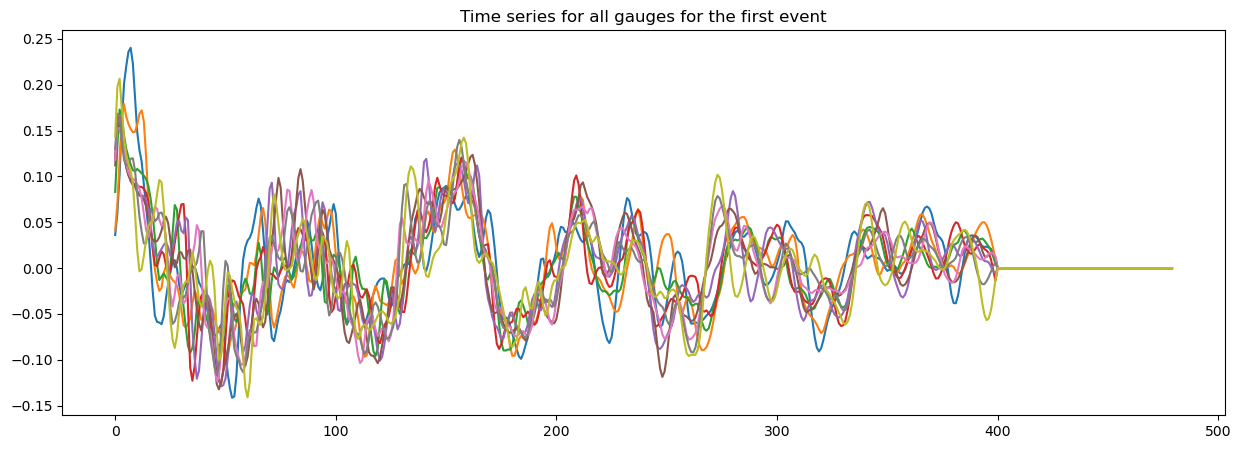

In [2]:
try:
    MLDir = os.getenv('MLDir')
    SimDir = os.getenv('SimDir')
    reg = 'CT'
    train_size = '4005' 
    test_size = '1' 
    mode = 'test'
    mask_size = '762'
except:
    raise Exception("*** Must first set variable")

# load test events related parameters
event_list_path = f'{MLDir}/data/events/shuffled_events_test_{reg}_{test_size}.txt'
event_list = np.loadtxt(event_list_path, dtype='str')
    
n_eve = len(event_list)    

flood_mask = ~np.load(f'{MLDir}/data/processed/zero_mask_{reg}_{mask_size}.npy')
zero_mask = np.load(f'{MLDir}/data/processed/zero_mask_{reg}_{mask_size}.npy')
nflood_grids = np.count_nonzero(flood_mask)

# Define the model region related size/architecture
if reg == 'SR':
   GaugeNo = list(range(53,58)) #rough pick for Siracusa
   x_dim = 1300  #lon
   y_dim = 948 #lat
   ts_dim = len(GaugeNo) #no of gauges time series
   reg_gaugeno = str(54)
   control_points = [[37.01,15.29],
      [37.06757,15.28709],
      [37.05266,15.26536],
      [37.03211,15.28632]]
elif reg == 'CT':
   GaugeNo = list(range(35,44)) #for Catania
   x_dim = 912
   y_dim = 2224
   ts_dim = len(GaugeNo)
   reg_gaugeno = str(38)
   control_points =  [[37.5022,15.0960],
      [37.48876,15.08936],
      [37.47193,15.07816],
      [37.46273,15.08527],
      [37.46252,15.08587],
      [37.45312,15.07874],
      [37.42821,15.08506],
      [37.40958,15.08075],
      [37.38595,15.08539],
      [37.35084,15.08575],
      [37.33049,15.07029],]
   
pts = 480
z = 64
hdim = 64
channels_off = [64,128,256]
channels_on = [16, 128, 128]
channels_deform = [16,32,64,128]

#for reading data
windowthreshold = 0.1
twindow = 480

#for evaluation
threshold = 0.2 #threshold for flooded or not in evaluation


import experiment as exp
exp.set_seed_settings(0)
# Load the model inputs for test events
t_array, red_d_array, red_dZ_array, dZ_array = exp.read_memmap(MLDir=MLDir,
                                                    reg=reg,
                                                    train_size=train_size,
                                                    test_size=test_size,
                                                    ts_dim=ts_dim,
                                                    pts_dim=pts,
                                                    x_dim=x_dim,
                                                    y_dim=y_dim,
                                                    n_eve = n_eve,
                                                    nflood_grids = nflood_grids,
                                                    what4 = mode,
                                                    normalize = False,
                                                    standardize = False,
                                                    twindow = twindow,
                                                    windowthreshold = windowthreshold,
                                                    GaugeNo = GaugeNo, # list(range(35,44)), #for Catania
                                                    reg_gaugeno = reg_gaugeno #'38',
                                                    )

In [3]:
dZ_array.shape

(11120, 2224, 912)

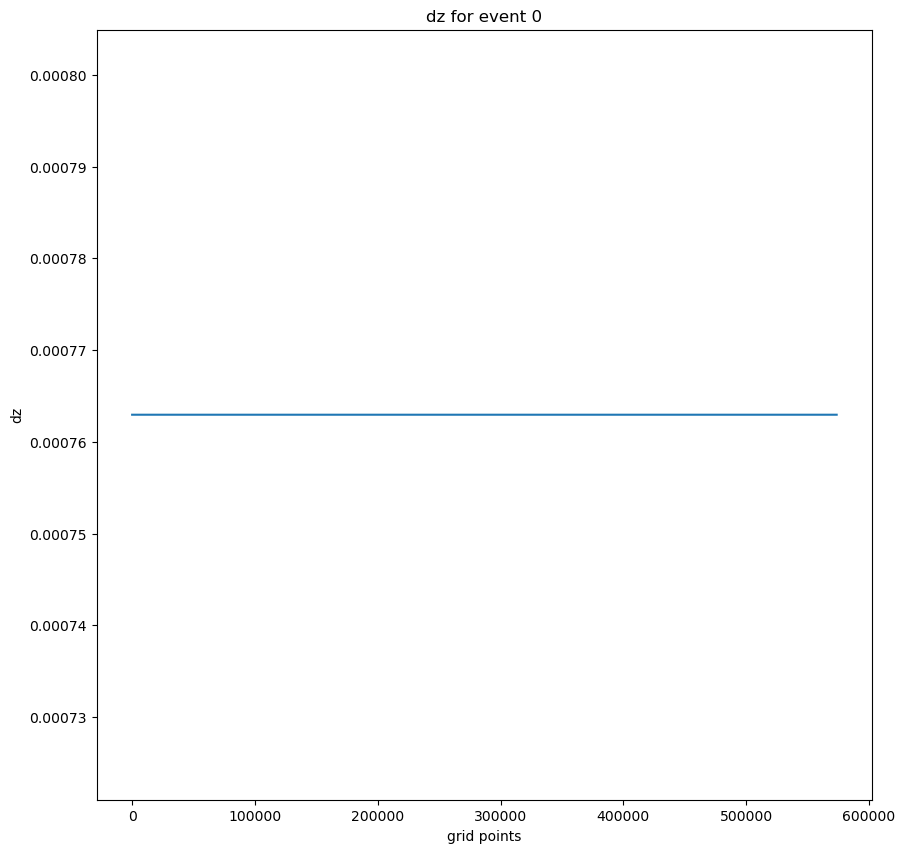

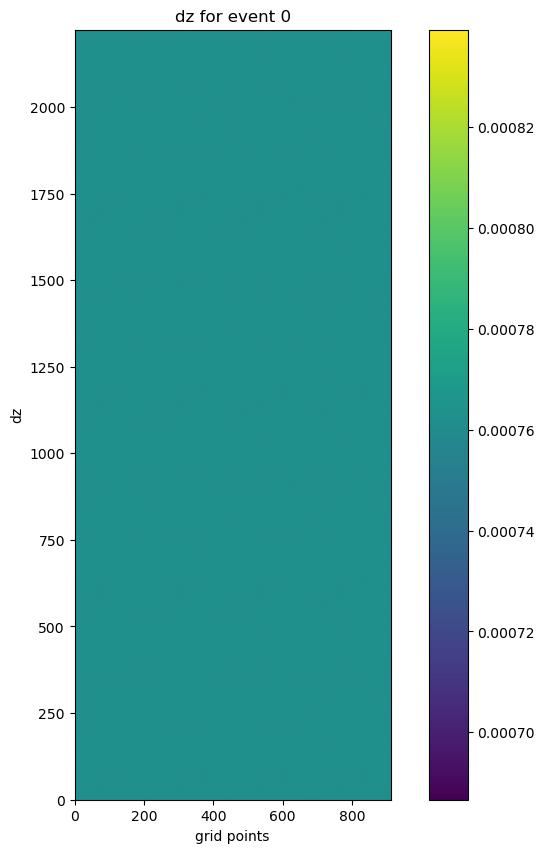

In [4]:
#plot dz for an event as 1 d array
plt.figure(figsize=(10,10))
plt.plot(red_dZ_array[0,:])
plt.title('dz for event 0')
plt.xlabel('grid points')
plt.ylabel('dz')
plt.show()

#plot dz for an event as 2d map
plt.figure(figsize=(10,10))
plt.imshow(dZ_array[0,:,:],origin='lower')
plt.title('dz for event 0')
plt.xlabel('grid points')
plt.ylabel('dz')
plt.colorbar()
plt.show()




In [5]:
def Gfit(obs, pred): #a normalized least-squares per event in first dimensions
    print('obs shape', obs.shape,obs.shape[0])
    Gtable = np.zeros(obs.shape[0])
    for i in range(obs.shape[0]):      
        obs_i = np.array(obs[i])
        pred_i = np.array(pred[i])
        Gvaluei = 1 - (2*np.sum(obs_i*pred_i)/(np.sum(obs_i**2)+np.sum(pred_i**2)))
        Gtable[i] = Gvaluei
    return Gtable

def Gfit_one(obs, pred): #a normalized least-squares
    obs = np.array(obs)
    pred = np.array(pred)
    Gvalue = 1 - (2*np.sum(obs*pred)/(np.sum(obs**2)+np.sum(pred**2)))
    return Gvalue

def l2norm(obs,thresh):
    obs = np.array(obs)
    return np.sqrt(np.sum(obs**2)/len(obs>thresh))    

CNN AutoEncoder model for offshore time series data

In [6]:
# offshore_model = torch.load(f"/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/scripts/testing/sacred_logs/54/model_offshore_ch_[64, 128, 256]_minepoch_6317.pt", map_location=torch.device('cpu'))
offshore_model = torch.load(f"{MLDir}/model/{reg}/out/model_offshore_ch_{channels_off}_minepoch_{train_size}.pt", map_location=torch.device('cpu'))


Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder_offshore                     [300, 9, 480]             --
├─Sequential: 1-1                        [300, 256, 60]            --
│    └─Conv1d: 2-1                       [300, 64, 480]            1,792
│    └─LeakyReLU: 2-2                    [300, 64, 480]            --
│    └─MaxPool1d: 2-3                    [300, 64, 240]            --
│    └─Conv1d: 2-4                       [300, 128, 240]           24,704
│    └─LeakyReLU: 2-5                    [300, 128, 240]           --
│    └─MaxPool1d: 2-6                    [300, 128, 120]           --
│    └─Conv1d: 2-7                       [300, 256, 120]           98,560
│    └─LeakyReLU: 2-8                    [300, 256, 120]           --
│    └─MaxPool1d: 2-9                    [300, 256, 60]            --
├─Sequential: 1-2                        [300, 64]                 --
│    └─Flatten: 2-10                     [300, 15360]              --
│   

Test loss: 0.00519
obs shape torch.Size([6421, 4320]) 6421
R2 score above 0.8: 6191
Gfit score below 0.1: 6123


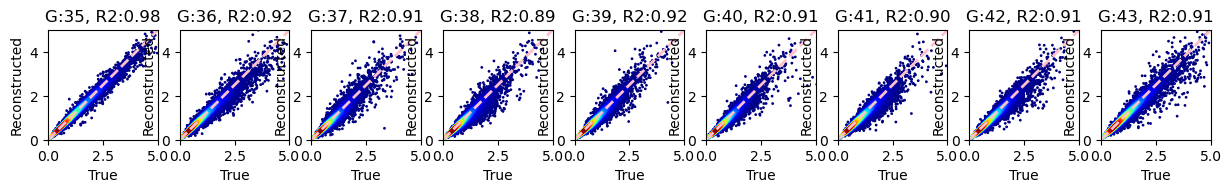

Text(0, 0.5, 'Score')

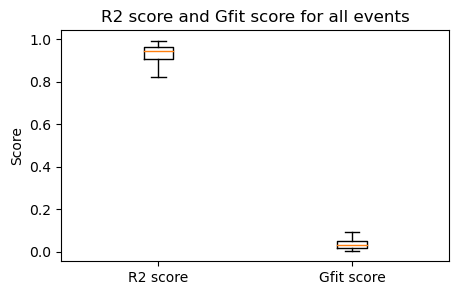

In [7]:
# Test model for final evaluation
#read model from file for testing
model = offshore_model
model.eval()
print(summary(model,(300,ts_dim,twindow)))
criterion = nn.MSELoss()
print(t_array.shape)
test_dataset = torch.tensor(t_array, dtype=torch.float32).to('cpu')
print(test_dataset.shape)
with torch.no_grad():
    recon_data = model(test_dataset)
tloss = criterion(recon_data, test_dataset)
print(f"Test loss: {tloss :.5f}")

recon_data = recon_data[:, :, :].cpu().detach().numpy()

# Flatten the tables along the n_gauge and n_time axes to get 2D arrays (neve, n_gauge * n_time)
flat_table1 = test_dataset.reshape(test_dataset.shape[0],-1)
flat_table2 = recon_data.reshape(recon_data.shape[0],-1)
Gfit_off = Gfit(flat_table1, flat_table2)

# Compute the R2 score for each event
flat_table1 = np.transpose(flat_table1)
flat_table2 = np.transpose(flat_table2)
r2_scores_off = r2_score(flat_table1, flat_table2, multioutput='raw_values')

#count events with score above 0.7
print('R2 score above 0.8:',np.sum(r2_scores_off > 0.8))
print('Gfit score below 0.1:',np.sum(Gfit_off < 0.1))


#plot per gauge
plt.figure(figsize=(15, 3))
for g in range(9):
    plt.subplot(1, 9, g+1)
    # plt.scatter(t_array[:, g, :].max(axis=1), recon_data[:, g, :].max(axis=1), s=1)
    x = t_array[:, g, :].max(axis=1)
    y = recon_data[:, g, :].max(axis=1)
    r2_score_gauge = r2_score(x, y) 

    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    index = z.argsort()
    x, y, z = x[index], y[index], z[index]

    plt.scatter(x, y, c=z, s=1, cmap='jet')  
    plt.title(f'G:{GaugeNo[g]}, R2:{r2_score_gauge:.2f}')
    plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='pink', linestyle='--', linewidth=2)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    plt.xlabel('True')
    plt.ylabel('Reconstructed')
plt.show()

#plot r2 /gfit score as box plot
plt.figure(figsize=(5,3))
# Create the first box plot for R2 scores
positions = [1, 2]
plt.boxplot(r2_scores_off, showfliers=False, positions=[positions[0]])
# Create the second box plot for Gfit scores
plt.boxplot(Gfit_off, showfliers=False, positions=[positions[1]])
plt.gca().set_xticks(positions)
plt.gca().set_xticklabels(['R2 score', 'Gfit score'])

plt.title('R2 score and Gfit score for all events')
plt.ylabel('Score')


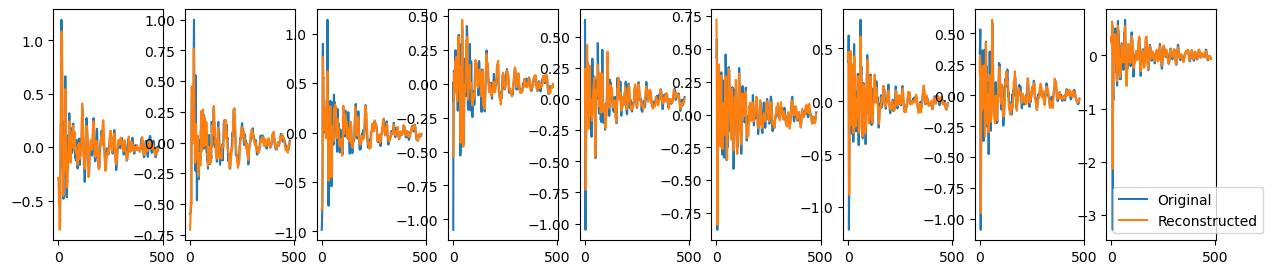

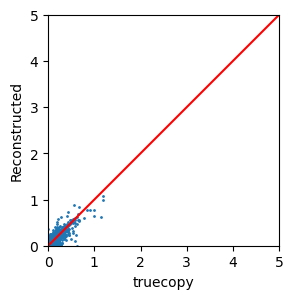

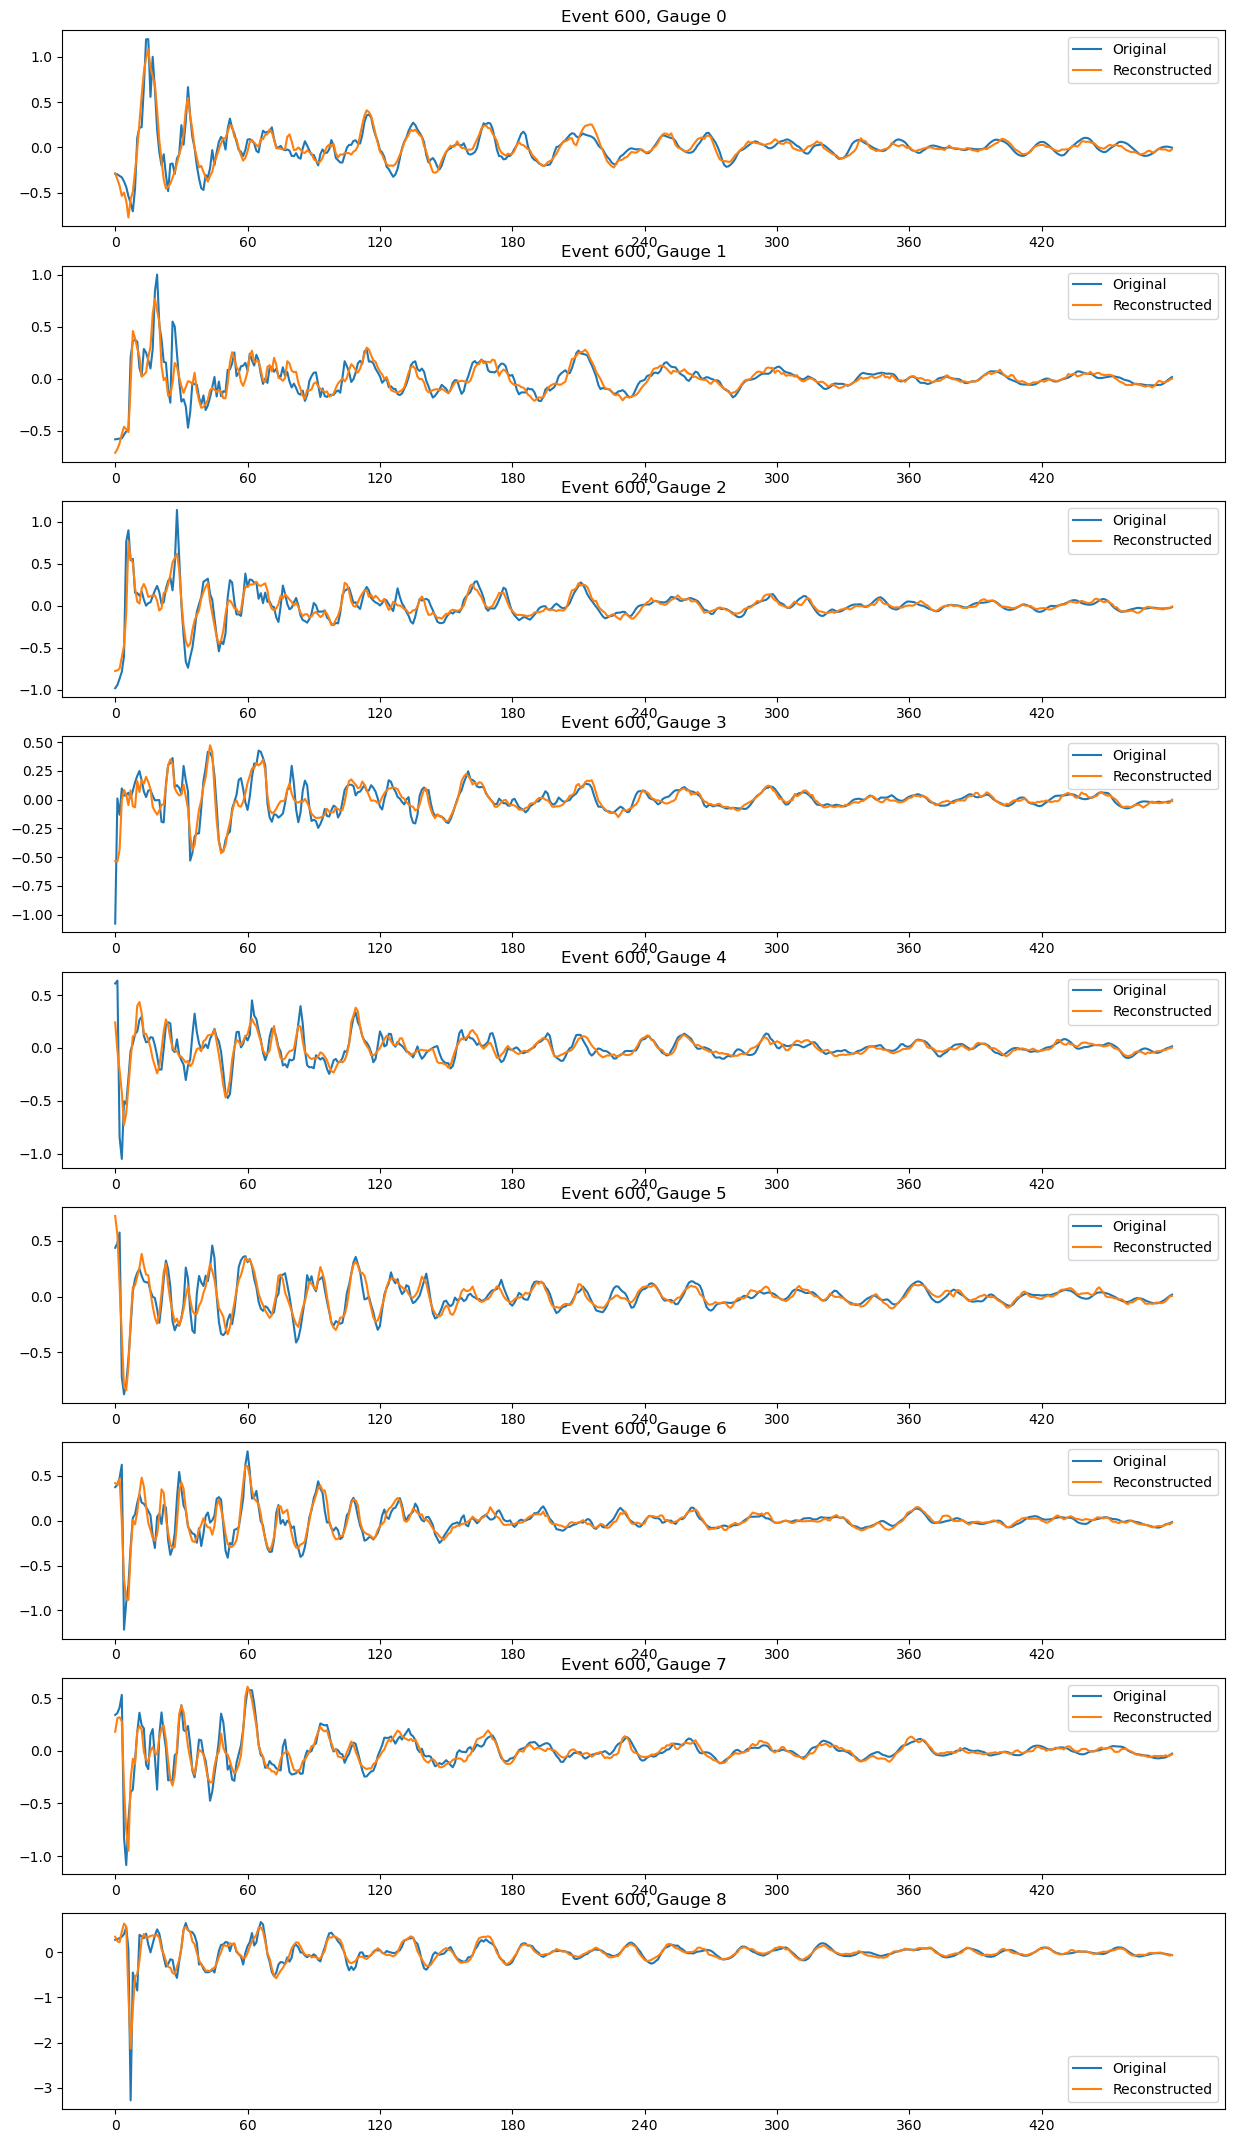

In [8]:
# Plot results all gauge
eve_no = 600
plt.figure(figsize=(15, 3))
for g in range(9):
    plt.subplot(1, 9, g+1)
    plt.plot(t_array[eve_no, g, :], label="Original")
    plt.plot(recon_data[eve_no, g, :], label="Reconstructed")
plt.legend()
plt.show()

plt.figure(figsize=(15, 3))
plt.scatter(flat_table1[:,eve_no], flat_table2[:,eve_no], s=1)
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel('truecopy')
plt.ylabel('Reconstructed')
plt.show()

# Zoomed in
# Plot results for all gauges for one event row wise
plt.figure(figsize=(15, 27))
for g in range(9):
    plt.subplot(9, 1, g+1)
    plt.title(f"Event {eve_no}, Gauge {g}")
    plt.plot(t_array[eve_no, g, :], label="Original")
    plt.plot(recon_data[eve_no, g, :], label="Reconstructed")
    plt.xticks(np.arange(0, 480, 60))
    plt.legend()
plt.show()

Onshore

In [8]:
print(summary(model,(300,nflood_grids,)))

Layer (type:depth-idx)                   Output Shape              Param #
AutoencoderSplitOnshore                  [300, 595141]             --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [300, 16]                 --
│    │    └─Linear: 3-1                  [300, 16]                 148,816
│    │    └─LeakyReLU: 3-2               [300, 16]                 --
│    └─Sequential: 2-2                   [300, 16]                 --
│    │    └─Linear: 3-3                  [300, 16]                 148,816
│    │    └─LeakyReLU: 3-4               [300, 16]                 --
│    └─Sequential: 2-3                   [300, 16]                 --
│    │    └─Linear: 3-5                  [300, 16]                 148,816
│    │    └─LeakyReLU: 3-6               [300, 16]                 --
│    └─Sequential: 2-4                   [300, 16]                 --
│    │    └─Linear: 3-7                  [300, 16]                 148

(11120, 573672)
torch.Size([11120, 573672])
Test loss: 0.00134
obs shape torch.Size([11120, 573672]) 11120
R2 score above 0.8: 9579
Gfit score below 0.1: 9215


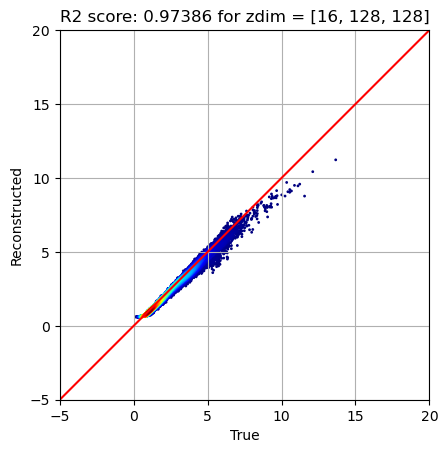

Text(0, 0.5, 'Score')

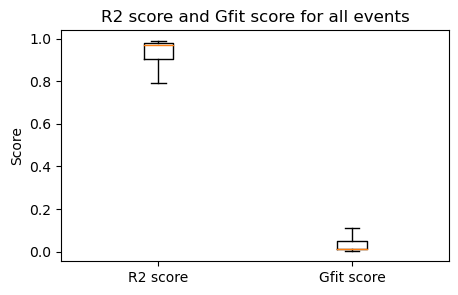

In [6]:
onshore_model = torch.load(f"{MLDir}/model/{reg}/out/model_onshoreparts_ch_{channels_on}_minepoch_{train_size}.pt", map_location=torch.device('cpu'))
# Test model for final evaluation
#read model from file for testing
model = onshore_model
model.eval()
# print(summary(model,(300,nflood_grids,)))
criterion = nn.MSELoss()
print(red_d_array.shape)
test_dataset = torch.tensor(red_d_array, dtype=torch.float32).to('cpu')
print(test_dataset.shape)

with torch.no_grad():
    recon_data = model(test_dataset)
tloss = criterion(recon_data, test_dataset)
print(f"Test loss: {tloss :.5f}")

recon_data = recon_data[:, :].cpu().detach().numpy()

# # Flatten the tables along the n_gauge and n_time axes to get 2D arrays (neve, n_gauge * n_time)
Gfit_on = Gfit(test_dataset, recon_data)
flat_table1 = np.transpose(test_dataset)
flat_table2 = np.transpose(recon_data)

# # Compute the R2 score for each event
r2_scores_on = r2_score(flat_table1, flat_table2, multioutput='raw_values')

# #count events with score above 0.7
print('R2 score above 0.8:',np.sum(r2_scores_on > 0.7))
print('Gfit score below 0.1:',np.sum(Gfit_on < 0.1))

# # Plot results max height for all events
test_max = np.max(red_d_array,axis=(1))
recon_max = np.max(recon_data,axis=(1))

# # plt.figure(figsize=(5, 5))
# plt.scatter(test_max, recon_max, s=1)  
x = test_max
y = recon_max

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
index = z.argsort()
x, y, z = x[index], y[index], z[index]
plt.scatter(x, y, c=z, s=1, cmap='jet')  
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
plt.title(f"R2 score: {r2_score(test_max, recon_max):.5f} for zdim = {channels_on}")
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-5, 20)
plt.ylim(-5, 20)
plt.grid()
plt.xlabel('True')
plt.ylabel('Reconstructed')
plt.show()

# #plot r2 /gfit score as box plot
plt.figure(figsize=(5,3))
# Create the first box plot for R2 scores
positions = [1, 2]
plt.boxplot(r2_scores_on, showfliers=False, positions=[positions[0]])
# Create the second box plot for Gfit scores
plt.boxplot(Gfit_on, showfliers=False, positions=[positions[1]])
plt.gca().set_xticks(positions)
plt.gca().set_xticklabels(['R2 score', 'Gfit score'])

plt.title('R2 score and Gfit score for all events')
plt.ylabel('Score')


-0.033662427 0.5996444
tensor(0.) tensor(0.1529)
0.9219936639164337


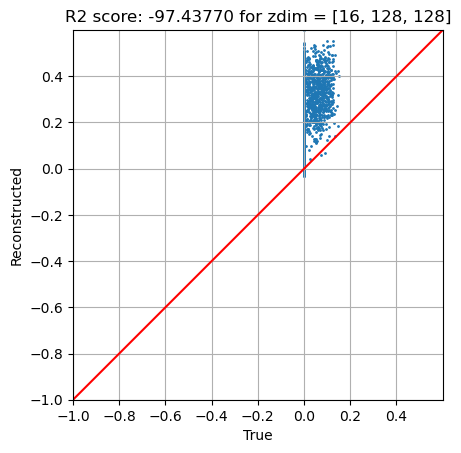

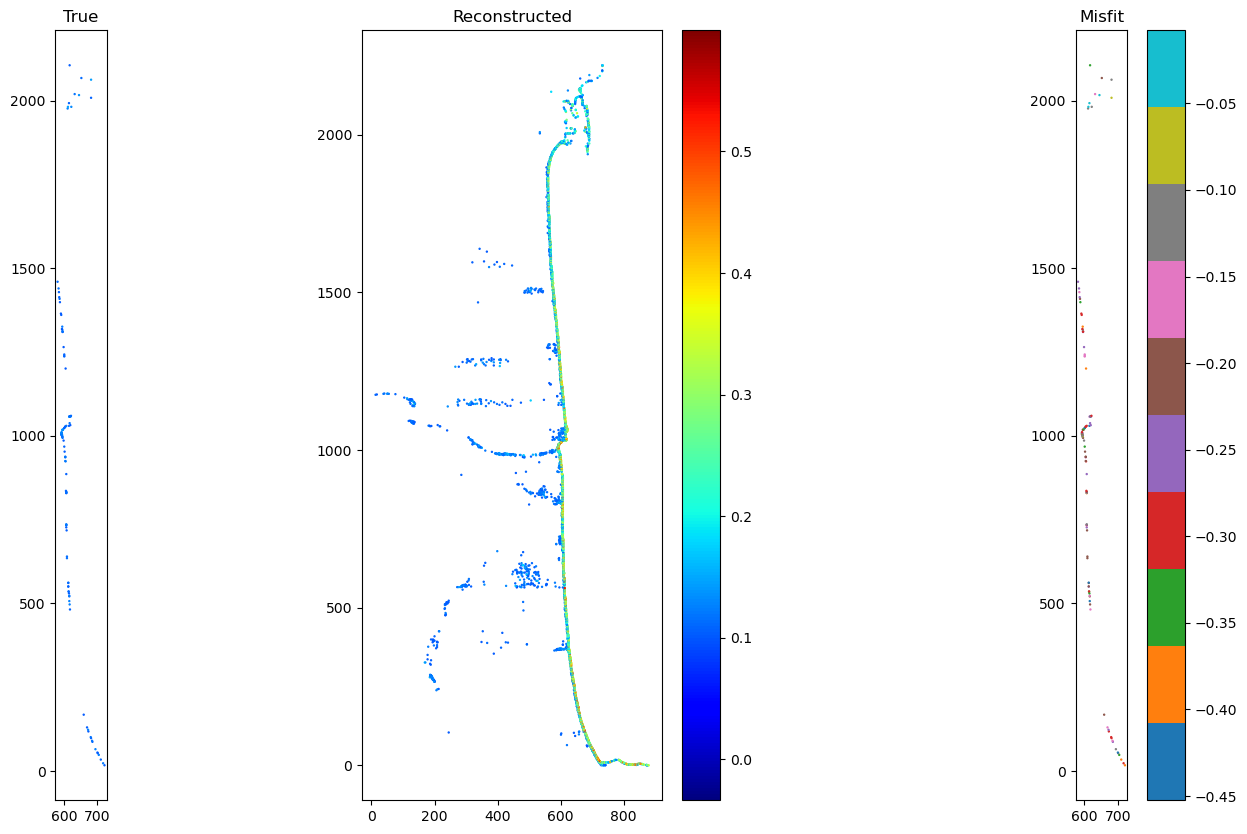

In [7]:
eve_no = 579#1954

print(min(recon_data[eve_no,:]), max(recon_data[eve_no,:]))
print(min(test_dataset[eve_no,:]), max(test_dataset[eve_no,:]))

minval = min(min(recon_data[eve_no,:]), min(test_dataset[eve_no,:]))
maxval = max(max(recon_data[eve_no,:]), max(test_dataset[eve_no,:]))

print(Gfit_on[eve_no])

plt.scatter(test_dataset[eve_no,:], recon_data[eve_no,:], s=1)
plt.title(f"R2 score: {r2_score(test_dataset[eve_no,:], recon_data[eve_no,:]):.5f} for zdim = {channels_on}")
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-1, maxval)
plt.ylim(-1, maxval)
plt.grid()
plt.xlabel('True')
plt.ylabel('Reconstructed')
plt.show()


idx= np.load('/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/data/processed/lat_lon_idx_CT_762.npy')
#add recon and true column to to the idx array
idx = np.c_[idx,test_dataset[eve_no],recon_data[eve_no]]
#set values below 0.1 to nan
idx[idx[:,4] < 0.1, 4] = np.nan
idx[idx[:,5] < 0.1, 5] = np.nan


# #set nan to 0
# idx[np.isnan(idx[:,4]), 4] = 0
# idx[np.isnan(idx[:,5]), 5] = 0


#plot the true and recon values on the map as color side by side using lat lon
plt.figure(figsize=(17,10))
plt.subplot(1,3,1)
plt.scatter(idx[:,1],idx[:,0],c=idx[:,4],s=0.5,cmap='jet')
plt.gca().set_aspect('equal', adjustable='box')
plt.title('True')
plt.clim(minval,maxval)
plt.subplot(1,3,2)
plt.scatter(idx[:,1],idx[:,0],c=idx[:,5],s=0.5,cmap='jet')
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Reconstructed')
plt.clim(minval,maxval)
plt.colorbar()
plt.subplot(1,3,3)
idx[idx[:,4] ==np.nan, 4] = 0
idx[idx[:,5] ==np.nan, 5] = 0
plt.scatter(idx[:,1],idx[:,0],c=idx[:,4]-idx[:,5],s=0.5,cmap='tab10')
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Misfit')
plt.colorbar()
plt.show()



Deform full field

In [30]:
# deform_model = torch.load(f"/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/model/backup/NGI/out/model_deformfull_ch_[16, 32, 64, 128]_minepoch_6317.pt", map_location=torch.device('cpu'))
deform_model = torch.load(f"{MLDir}/model/{reg}/out/model_deformfull_ch_{channels_deform}_minepoch_{train_size}.pt", map_location=torch.device('cpu')) # Test model for final evaluation
#read model from file for testing
model = deform_model
model.eval()
print(summary(model,(100,x_dim,y_dim)))
criterion = nn.MSELoss()
print(red_dZ_array.shape)
test_dataset = torch.tensor(dZ_array[1000:2000], dtype=torch.float32).to('cpu')
print(test_dataset.shape)

with torch.no_grad():
    recon_data = model(test_dataset)
tloss = criterion(recon_data, test_dataset)
print(f"Test loss: {tloss :.5f}", end="\r")

recon_data = recon_data[:, :].cpu().detach().numpy()
test_dataset = test_dataset[:, :].cpu().detach().numpy()


Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder_deformationf                 [100, 2224, 912]          --
├─Sequential: 1-1                        [100, 128, 7, 18]         --
│    └─Conv2d: 2-1                       [100, 16, 456, 1112]      160
│    └─LeakyReLU: 2-2                    [100, 16, 456, 1112]      --
│    └─MaxPool2d: 2-3                    [100, 16, 228, 556]       --
│    └─Conv2d: 2-4                       [100, 32, 114, 278]       4,640
│    └─LeakyReLU: 2-5                    [100, 32, 114, 278]       --
│    └─MaxPool2d: 2-6                    [100, 32, 57, 139]        --
│    └─Conv2d: 2-7                       [100, 64, 29, 70]         18,496
│    └─LeakyReLU: 2-8                    [100, 64, 29, 70]         --
│    └─MaxPool2d: 2-9                    [100, 64, 14, 35]         --
│    └─Conv2d: 2-10                      [100, 128, 7, 18]         73,856
│    └─LeakyReLU: 2-11                   [100, 128, 7, 18]         --
│  

torch.Size([1000, 2224, 912])


obs shape (1000, 2028288) 1000


994 events with R2 score above 0.7
994 events with Gfit score below 0.1


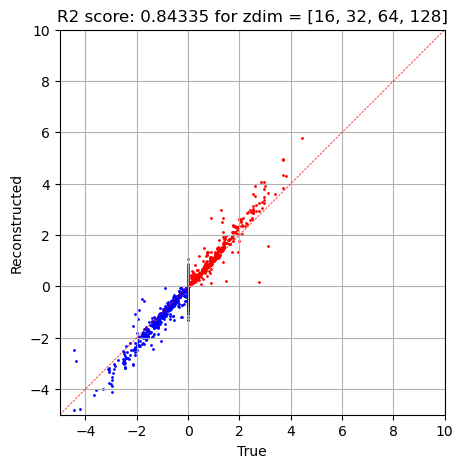

Text(0, 0.5, 'Score')

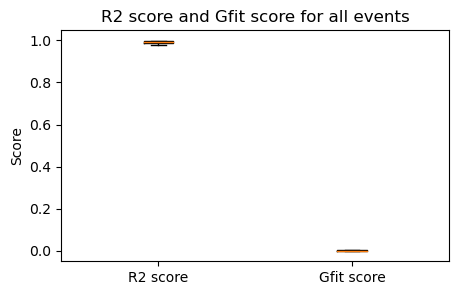

In [23]:
flat_table1 = test_dataset.reshape(test_dataset.shape[0],-1)
flat_table2 = recon_data.reshape(recon_data.shape[0],-1)
Gfit_def = Gfit(flat_table1, flat_table2)

# Compute the R2 score for each event
flat_table1 = np.transpose(flat_table1)
flat_table2 = np.transpose(flat_table2)
r2_scores_def = r2_score(flat_table1, flat_table2, multioutput='raw_values')

# #count events with score above 0.7
print(np.sum(r2_scores_def > 0.7), 'events with R2 score above 0.7')
print(np.sum(Gfit_def < 0.1), 'events with Gfit score below 0.1')


# Plot results max height for all events
test_max = np.max(flat_table1,axis=(0))
recon_max = np.max(flat_table2,axis=(0))
test_min = np.min(flat_table1,axis=(0))
recon_min = np.min(flat_table2,axis=(0))

plt.figure(figsize=(5, 5))
plt.scatter(test_max, recon_max, s=1,c = 'red') 
plt.scatter(test_min, recon_min, s=1,c = 'blue')

plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red', linestyle='--', linewidth=0.5)
plt.title(f"R2 score: {r2_score(test_max, recon_max):.5f} for zdim = {channels_deform}")
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-5, 10)
plt.ylim(-5, 10)
plt.grid()
plt.xlabel('True')
plt.ylabel('Reconstructed')
plt.show()

#plot r2 /gfit score as box plot
plt.figure(figsize=(5,3))
# Create the first box plot for R2 scores
positions = [1, 2]
plt.boxplot(r2_scores_def, showfliers=False, positions=[positions[0]])
# Create the second box plot for Gfit scores
plt.boxplot(Gfit_def, showfliers=False, positions=[positions[1]])
plt.gca().set_xticks(positions)
plt.gca().set_xticklabels(['R2 score', 'Gfit score'])

plt.title('R2 score and Gfit score for all events')
plt.ylabel('Score')

-1.4137257 0.55676925


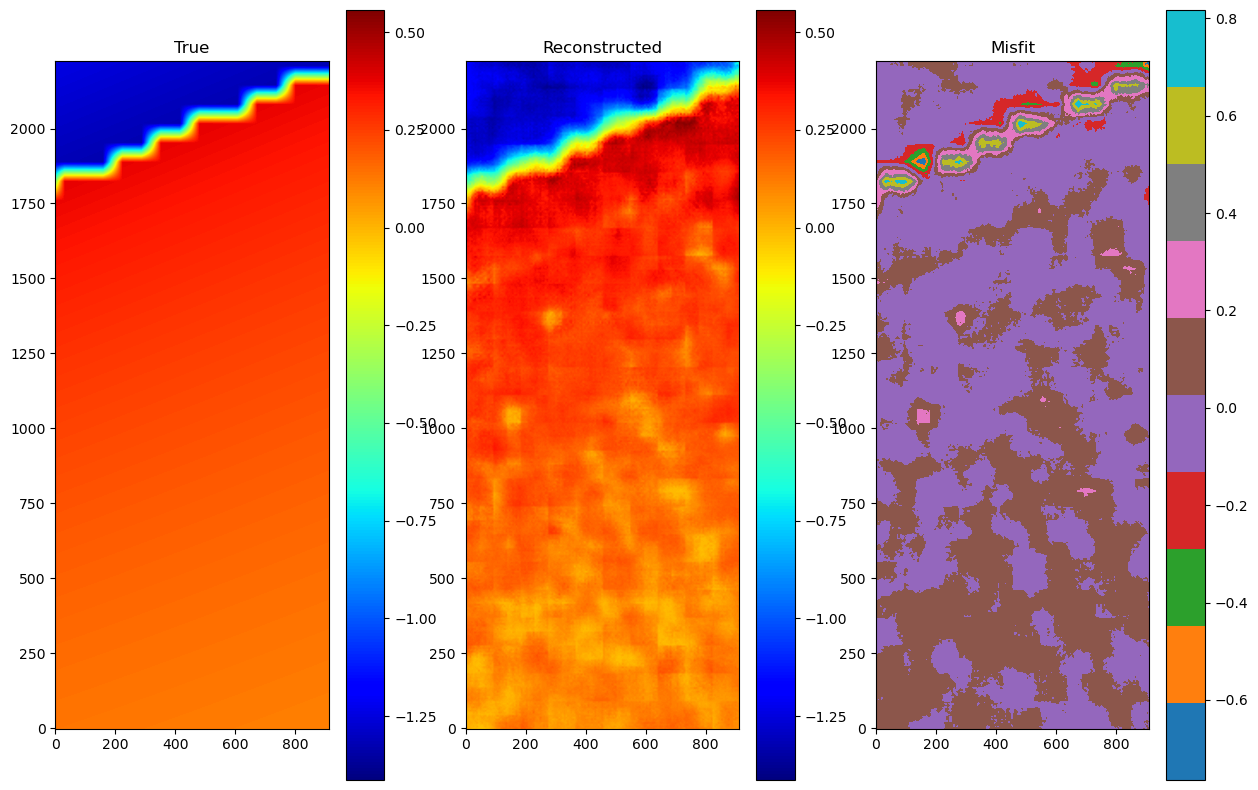

In [31]:
eve_no = 856
minval = min(np.min(test_dataset[eve_no,:,:]),np.min(recon_data[eve_no,:,:]))
maxval = max(np.max(test_dataset[eve_no,:,:]), np.max(recon_data[eve_no,:,:]))
print(minval,maxval)
#plot the true and recon values on the map as color side by side using lat lon 
plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(test_dataset[eve_no,:,:],origin='lower',cmap='jet')
plt.title('True')
plt.clim(minval,maxval)
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(recon_data[eve_no,:,:],origin='lower',cmap='jet')
plt.title('Reconstructed')
plt.clim(minval,maxval)
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(test_dataset[eve_no,:,:]-recon_data[eve_no,:,:],origin='lower',cmap='tab10')
plt.title('Misfit')
plt.colorbar()
plt.show()



Final Coupled Model

In [6]:
couple_model = torch.load(f'{MLDir}/model/{reg}/out/model_couple_off{channels_off}_on{channels_on}_minepoch_{train_size}.pt', map_location=torch.device('cpu'))

#read model from file for testing
model = couple_model
model.eval()
print(summary(model,[(300,ts_dim,pts),(300,nflood_grids,),(300,x_dim,y_dim)]))
criterion = nn.MSELoss()

# print(t_array.shape)
# test_dataset_in = torch.tensor(t_array[:2000], dtype=torch.float32).to('cpu')
# print(test_dataset_in.shape)
# print(red_d_array.shape)
# test_dataset_out = torch.tensor(red_d_array[:2000], dtype=torch.float32).to('cpu')
# print(test_dataset_out.shape)
# print(red_dZ_array.shape)
# test_dataset_deform = torch.tensor(red_dZ_array[:2000], dtype=torch.float32).to('cpu')
# print(test_dataset_deform.shape)
# test_dataset_deformfull = torch.tensor(dZ_array[:2000], dtype=torch.float32).to('cpu')
# print(test_dataset_deform.shape)

# #evaluate model in batch and combine reconstructions to get full dataset

# with torch.no_grad():
#     recon_data = model(test_dataset_in, test_dataset_deform, test_dataset_deformfull)
# tloss = criterion(recon_data, test_dataset_out)
# print(f"Test loss: {tloss :.5f}")
# recon_data1 = recon_data[:, :].cpu().detach().numpy()


Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder_coupled2                     [300, 573672]             --
├─Sequential: 1-1                        [300, 256, 60]            --
│    └─Conv1d: 2-1                       [300, 64, 480]            (1,792)
│    └─LeakyReLU: 2-2                    [300, 64, 480]            --
│    └─MaxPool1d: 2-3                    [300, 64, 240]            --
│    └─Conv1d: 2-4                       [300, 128, 240]           (24,704)
│    └─LeakyReLU: 2-5                    [300, 128, 240]           --
│    └─MaxPool1d: 2-6                    [300, 128, 120]           --
│    └─Conv1d: 2-7                       [300, 256, 120]           (98,560)
│    └─LeakyReLU: 2-8                    [300, 256, 120]           --
│    └─MaxPool1d: 2-9                    [300, 256, 60]            --
├─Sequential: 1-2                        [300, 64]                 --
│    └─Flatten: 2-10                     [300, 15360]              -

In [7]:
#run in loop to avoid memory error
recon_data = []
len_eve = t_array.shape[0]
batch = 1000

for i in range(0,len_eve,batch):
    print(i)
    test_dataset_in = torch.tensor(t_array[i:i+batch], dtype=torch.float32).to('cpu')
    test_dataset_deform = torch.tensor(red_dZ_array[i:i+batch], dtype=torch.float32).to('cpu')
    test_dataset_deformfull = torch.tensor(dZ_array[i:i+batch], dtype=torch.float32).to('cpu')
    with torch.no_grad():
        recon_data_i = model(test_dataset_in, test_dataset_deform, test_dataset_deformfull)
    recon_data.append(recon_data_i.cpu().detach().numpy())

recon_data = np.concatenate(recon_data,axis=0)

del test_dataset_in, test_dataset_deform, test_dataset_deformfull



0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000


In [77]:
# torch.save(model, f'{MLDir}/model/{reg}/out/try_model_couple_ch_{channels_off}_on_{channels_on}_deform_{channels_deform}_minepoch_{train_size}.pt')

In [4]:
# recon_data = np.load(f'{MLDir}/model/{reg}/out/pred_trainsize{train_size}_testsize{test_size}.npy')

Analysis and plotting

obs shape (11120, 573672) 11120
8857 events with R2 score above 0.7
8522 events with Gfit score below 0.1


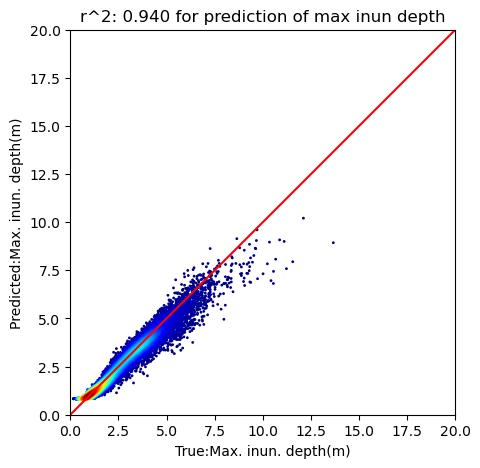

Text(0, 0.5, 'Score')

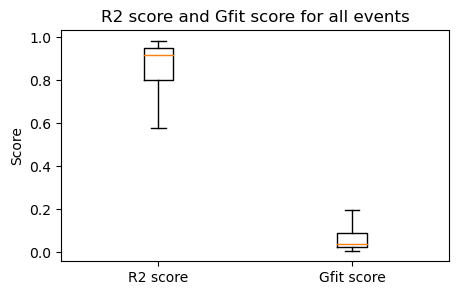

In [8]:
# # Flatten the tables along the n_gauge and n_time axes to get 2D arrays (neve, n_gauge * n_time)
Gfit_out = Gfit(red_d_array, recon_data)
flat_table1 = np.transpose(red_d_array)
flat_table2 = np.transpose(recon_data)

# Compute the R2 score for each event
r2_scores_out = r2_score(flat_table1, flat_table2, multioutput='raw_values')

# Plot results max height for all events
test_max = np.max(red_d_array,axis=(1))
recon_max = np.max(recon_data,axis=(1))

# #count events with score above 0.7
print(np.sum(r2_scores_out > 0.7), 'events with R2 score above 0.7')
print(np.sum(Gfit_out < 0.1), 'events with Gfit score below 0.1')

x = test_max
y = recon_max

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
index = z.argsort()
x, y, z = x[index], y[index], z[index]
plt.figure(figsize=(7, 5))
plt.scatter(x, y, c=z, s=1, cmap='jet') 
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red',)
plt.title(f"r^2: {r2_score(test_max, recon_max):.3f} for prediction of max inun depth")
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0, 20)
plt.ylim(0, 20)
# plt.grid()
plt.xlabel('True:Max. inun. depth(m)')
plt.ylabel('Predicted:Max. inun. depth(m)')
plt.show()

#plot r2 /gfit score as box plot
plt.figure(figsize=(5,3))
# Create the first box plot for R2 scores
positions = [1, 2]
plt.boxplot(r2_scores_out, showfliers=False, positions=[positions[0]])
# Create the second box plot for Gfit scores
plt.boxplot(Gfit_out, showfliers=False, positions=[positions[1]])
plt.gca().set_xticks(positions)
plt.gca().set_xticklabels(['R2 score', 'Gfit score'])

plt.title('R2 score and Gfit score for all events')
plt.ylabel('Score')

In [9]:
# #save reconstructions
# np.save(f'{MLDir}/scripts/testing/out/recon_data_{reg}_{test_size}.npy',recon_data)
# #save r2 and gfit scores
# np.save(f'{MLDir}/scripts/testing/out/r2_scores_{reg}_{test_size}.npy',r2_scores_out)
# np.save(f'{MLDir}/scripts/testing/out/Gfit_{reg}_{test_size}.npy',Gfit_out)

In [10]:
# #read reconstructions and scores
# recon_data = np.load(f'{MLDir}/scripts/testing/out/recon_data_{reg}_{test_size}.npy')
# r2_scores_out = np.load(f'{MLDir}/scripts/testing/out/r2_scores_{reg}_{test_size}.npy')
# Gfit_out = np.load(f'{MLDir}/scripts/testing/out/Gfit_{reg}_{test_size}.npy')

In [9]:
eve_no = 9396#1854#5#600#5661

-0.04199748 1.4112223
0.0 1.2419483661651611
0.15910620954034893


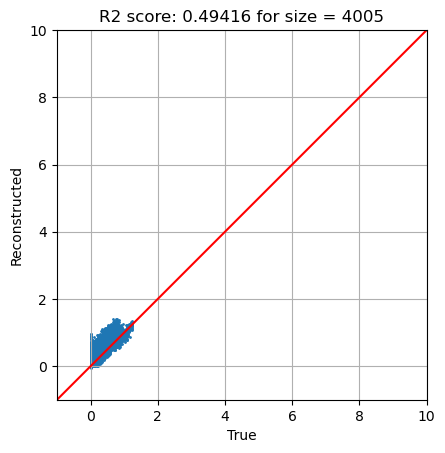

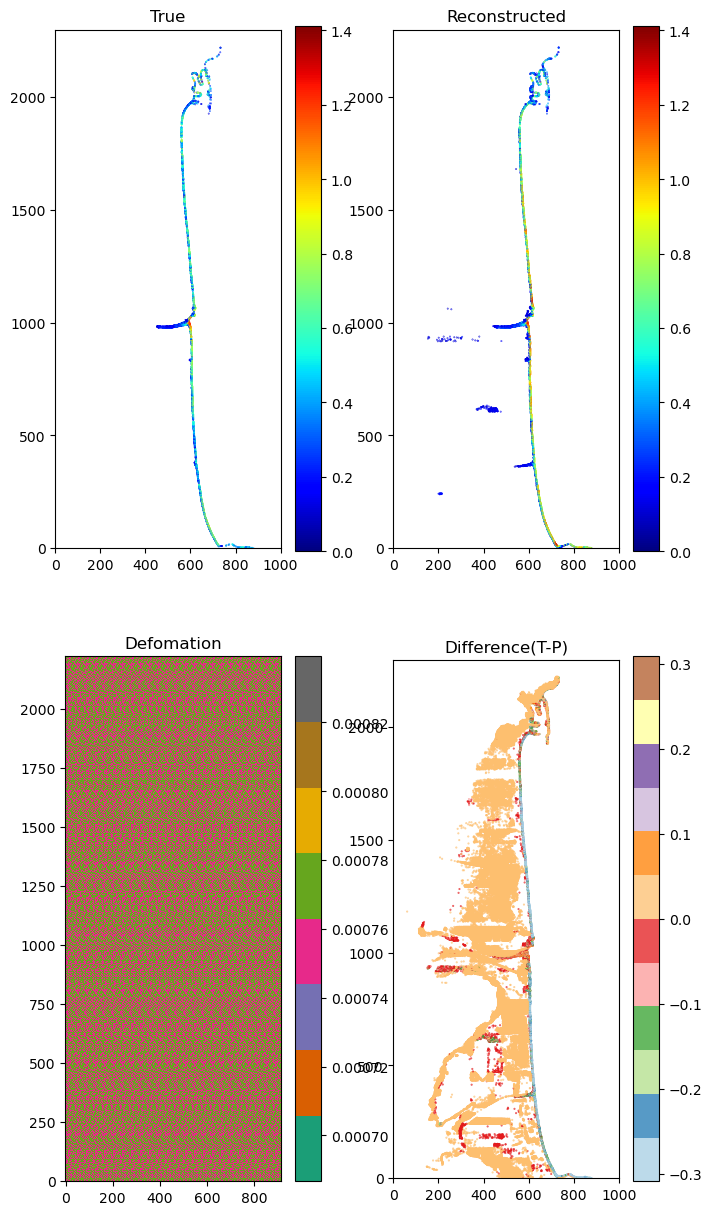

In [79]:

print(min(recon_data[eve_no,:]), max(recon_data[eve_no,:]))
print(min(red_d_array[eve_no,:]), max(red_d_array[eve_no,:]))

minval = min(min(recon_data[eve_no,:]), min(red_d_array[eve_no,:]))
maxval = max(max(recon_data[eve_no,:]), max(red_d_array[eve_no,:]))

print(Gfit_out[eve_no])

plt.scatter(red_d_array[eve_no,:], recon_data[eve_no,:], s=1)
plt.title(f"R2 score: {r2_score(red_d_array[eve_no,:], recon_data[eve_no,:]):.5f} for size = {train_size}")
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-1, 10)
plt.ylim(-1, 10)
plt.grid()
plt.xlabel('True')
plt.ylabel('Reconstructed')
plt.show()

idx= np.load('/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/data/processed/lat_lon_idx_CT_762.npy')
#add recon and true column to to the idx array as column 4 and 5
idx = np.c_[idx,red_d_array[eve_no],red_dZ_array[eve_no],recon_data[eve_no]]

#add difference as column 6, use nan and values less than 0.1 as 0
# idx[np.where(idx[:,4] <= 0.001),4] = 0 
# idx[np.where(idx[:,5] <= 0.001),6] = 0
# idx[np.where(idx[:,4] == np.nan),4] = 0
# idx[np.where(idx[:,5] == np.nan),6] = 0
idx = np.c_[idx,red_d_array[eve_no]-recon_data[eve_no]]

cutmax = np.max(idx[:, 7])
cutmin = np.min(idx[:, 7])

# #plot the true and recon values on the map as color side by side using lat lon 
# plt.figure(figsize=(21, 7))
# # Plot True
# plt.subplot(1, 4, 1)
# #sort idx by true and set values less than 0.1 to nan
# idx = idx[np.argsort(idx[:, 4])]
# data2plot = idx[:, 4]
# data2plot[np.where(data2plot < 0.1)] = np.nan
# true_scatter = plt.scatter(idx[:, 1], idx[:, 0], c=data2plot, s=1, cmap='jet')
# plt.gca().set_aspect('equal', adjustable='box')
# plt.title('True')
# plt.clim(0, maxval)
# plt.xlim(0, 1000)
# plt.ylim(0, 2300)
# plt.colorbar()

# # Plot Deformation 
# # plt.subplot(1, 4, 2)
# # #sort idx by recon and set values less than 0.1 to nan
# # idx = idx[np.argsort(idx[:, 5])]
# # data2plot = idx[:, 5]
# # reconstructed_scatter = plt.scatter(idx[:, 1], idx[:, 0], c=data2plot, s=.1, cmap='Accent')
# # plt.gca().set_aspect('equal', adjustable='box')
# # plt.title('Defomation')
# # plt.xlim(0, 1000)
# # plt.ylim(0, 2300)
# # plt.colorbar()

# # Plot Reconstructed with transparency for values less than 0.1
# plt.subplot(1, 4, 2)
# #sort idx by recon and set values less than 0.1 to nan

# reconstructed_scatter = plt.scatter(idx[:, 1], idx[:, 0], c=data2plot, s=.1, cmap='jet')
# plt.gca().set_aspect('equal', adjustable='box')
# plt.title('Reconstructed')
# plt.clim(0, maxval)
# plt.xlim(0, 1000)
# plt.ylim(0, 2300)
# plt.colorbar()

# #plot deform full
# plt.subplot(1, 4, 3)
# plt.imshow(dZ_array[eve_no,:,:],origin='lower',cmap='Accent')
# plt.gca().set_aspect('equal', adjustable='box')
# plt.title('Defomation')
# plt.colorbar()
# plt.show()

# # Plot the difference between the two
# plt.subplot(1, 4, 4)


# #sort idx by difference and set values less than 0.1 to nan

# plt.scatter(idx[:, 1], idx[:, 0], c=data2plot, s=.1, cmap='tab10',alpha=0.75)
# plt.gca().set_aspect('equal', adjustable='box')
# plt.title('Difference(T-P)')
# plt.clim(-cutmax,cutmax)
# plt.xlim(0, 1000)
# plt.ylim(0, 2300)
# plt.colorbar()
# plt.show()

#plot all 4 on one of size 16*10
plt.figure(figsize=(8,15))
# idx = idx[np.argsort(idx[:, 6])]
data2plot = idx[:, 4]
data2plot[np.where(data2plot <= 0.1)] = np.nan
plt.subplot(2,2,1)
plt.scatter(idx[:, 1], idx[:, 0], c=data2plot, s=.1, cmap='jet')
plt.gca().set_aspect('equal', adjustable='box')
plt.title('True')
plt.clim(0, maxval)
plt.xlim(0, 1000)
plt.ylim(0, 2300)
plt.colorbar()

plt.subplot(2,2,2)
# idx = idx[np.argsort(idx[:, 6])]
data2plot = idx[:, 6]
data2plot[np.where(data2plot <=0.1)] = np.nan  
plt.scatter(idx[:, 1], idx[:, 0], c=data2plot, s=.1, cmap='jet')
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Reconstructed')
plt.clim(0, maxval)
plt.xlim(0, 1000)
plt.ylim(0, 2300)
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(dZ_array[eve_no,:,:],origin='lower',cmap='Dark2')
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Defomation')
plt.colorbar()

plt.subplot(2,2,4)
# idx = idx[np.argsort(idx[:, 6])]
data2plot = idx[:, 7]
data2plot[np.where(np.abs(data2plot) <= 0.01)] = np.nan
plt.scatter(idx[:, 1], idx[:, 0], c=data2plot, s=.25, cmap='Paired',alpha=0.75)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Difference(T-P)')
plt.clim(-cutmax,cutmax)
plt.xlim(0, 1000)
plt.ylim(0, 2300)
plt.colorbar()
plt.show()


In [10]:
def calc_scores(true,pred,locindices,threshold=0.2):
    truecopy = true.copy()
    #only test where there is significant flooding
    truecopy[truecopy<threshold] = 0
    pred[pred<threshold] = 0
    mse_val = mean_squared_error(truecopy,pred)
    r2_val = r2_score(truecopy,pred)
    Gfit_val = Gfit_one(truecopy,pred)
    l2n_val = l2norm(truecopy,threshold)
    pt_er = truecopy[locindices] - pred[locindices]

    #calculate Aidan's no K and k small
    # ratio = true[true>=threshold]/pred[true>=threshold]    
    # logK = np.exp((np.log(ratio)).mean()) # Aidan's no K
    # logksmall = (np.mean((np.log(ratio))**2) - (logK**2))**0.5
    # Kcap = np.exp(logK)
    # Ksmall = np.exp(logksmall)

    return mse_val,r2_val,truecopy[locindices],pred[locindices],pt_er,Gfit_val,l2n_val#,Kcap,Ksmall


In [11]:
if reg == 'CT':
  control_points =  [[37.5022,15.0960],
            [37.48876,15.08936],
            [37.47193,15.07816],
            [37.46851,15.08337], #airport 37.46851594, 15.08337672
            [37.46252,15.08587],
            [37.45312,15.07874],
            [37.42821,15.08506],
            [37.40958,15.08075],
            [37.38595,15.08539],
            [37.35084,15.08575],
            [37.33049,15.07029],
            [37.40675,15.05037] 
            ]
elif reg == 'SR':
  control_points = [[37.01,15.29],
      [37.06757,15.28709],
      [37.05266,15.26536],
      [37.03211,15.28632]]


def get_idx_from_latlon(locations,reg=reg,MLDir=MLDir,SimDir=SimDir,mask_size=mask_size):  
    #get first event to get lat lon
    firstevent = np.loadtxt(f'{MLDir}/data/events/sample_events53550.txt',dtype='str')[0]
    D_grids = xr.open_dataset(f'{SimDir}/{firstevent}/{reg}_flowdepth.nc')
    zero_mask = np.load(f'{MLDir}/data/processed/zero_mask_{reg}_{mask_size}.npy')
    non_zero_list = np.argwhere(~zero_mask).tolist()

    #iterate over list locations
    indices = []
    for loc in locations: 
        #get index of lat lon
        lat_idx = np.argmin(np.abs(D_grids.lat.values - loc[0]))
        lon_idx = np.argmin(np.abs(D_grids.lon.values - loc[1]))

        #get idx in non zero mask list from lat_idx and lon_idx
        idx = non_zero_list.index([lat_idx,lon_idx])
        indices.append(idx)

    # return lat_idx, lon_idx, idx
    print(indices)


    #calculate lat lon for all non zero list



    return indices

locindices = get_idx_from_latlon(control_points)
        #points to evaluate
# (2130, 653, 416589)
# (1980, 595, 406966)
# (1794, 496, 382850)
# (1691, 559, 366654)
# (1689, 564, 366384)
# (1585, 501, 348891)
# (1308, 557, 300485)
# (1101, 519, 261213)
# (839, 560, 196458)
# (450, 563, 127165)
# (224, 427, 61790)
# (1070, 252, 252416)



[568046, 555913, 525243, 517358, 502097, 476943, 399701, 326371, 231655, 157045, 83018, 311948]


In [12]:
#check performance per event
eve_perf = []
true_list = []
pred_list = []
er_list = []
threshold = 0.2

#mse_val,r2_val,true[locindices],pred[locindices],pt_er,Gfit_val #,KCap,Ksmall
for eve_no,eve in enumerate(event_list):
    if eve_no % 1000==0:
        print(eve_no)
    scores = calc_scores(red_d_array[eve_no,:], recon_data[eve_no,:],locindices,threshold)
    eve_perf.append([scores[0],scores[1],scores[5],scores[6],#scores[7], #mse,r2,Gfit,l2n
                     np.count_nonzero(red_d_array[eve_no,:]), #true count
                     np.count_nonzero(recon_data[eve_no,:])]), #pred count
    
    true_list.append(scores[2])
    pred_list.append(scores[3])
    er_list.append(scores[4])

#count of events less than 
eve_perf = np.array(eve_perf)
true_list = np.array(true_list)
pred_list = np.array(pred_list)
er_list = np.array(er_list)

#combine columns of true,pred,er into 12 column array
true_pred_er = np.column_stack((true_list,pred_list,er_list))

#append column with value from multiplie of column 0 and 4(total error)
eve_perf = np.column_stack((eve_perf,eve_perf[:,0]*eve_perf[:,4]))

#save to file
# np.savetxt(f"{MLDir}/scripts/testing/out/er_coupled_finetuned_epoch_min_{test_size}.csv",true_pred_er,fmt='%.5f',delimiter=',')
# np.savetxt(f"{MLDir}/scripts/testing/out/eve_perf_coupled_finetuned_epoch_min_{test_size}.csv",eve_perf,fmt='%.5f',delimiter=',')


0


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000


In [15]:
# #load from file
# true_pred_er = np.loadtxt(f"{MLDir}/scripts/testing/out/er_coupled_finetuned_epoch_min_{test_size}.csv",delimiter=',')
# eve_perf = np.loadtxt(f"{MLDir}/scripts/testing/out/eve_perf_coupled_finetuned_epoch_min_{test_size}.csv",delimiter=',')

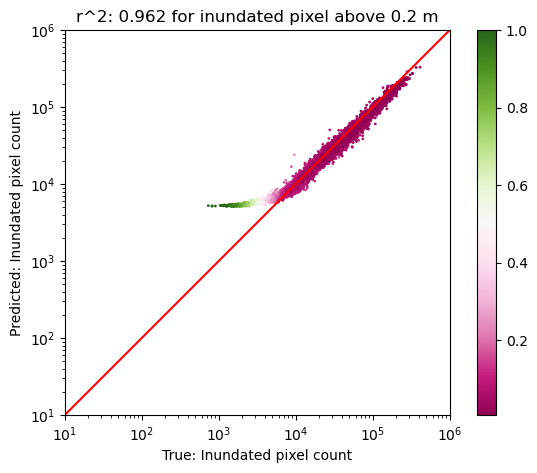

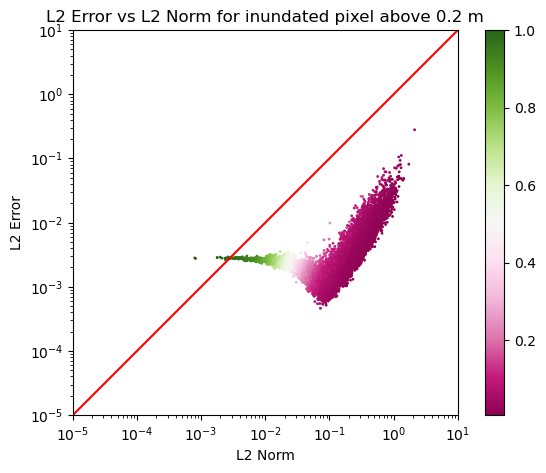

In [83]:
#plot scatter of flood count
plt.figure(figsize=(7, 5))
plt.scatter(eve_perf[:,4], eve_perf[:,5], s=1, c=eve_perf[:,2], cmap='PiYG')
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red',)
plt.title(f"r^2: {r2_score(eve_perf[:,4], eve_perf[:,5]):.3f} for inundated pixel above 0.2 m")
plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
#use log scale
plt.xscale('log')
plt.yscale('log')
plt.xlim(10, 1000000)
plt.ylim(10, 1000000)
# plt.grid()
plt.xlabel('True: Inundated pixel count')
plt.ylabel('Predicted: Inundated pixel count')
plt.show()

#plot scatter of mse vs l2norm
plt.figure(figsize=(7, 5))
plt.scatter(eve_perf[:,3], eve_perf[:,0], s=1, c=eve_perf[:,2], cmap='PiYG')
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red',)
plt.colorbar()
plt.title(f"L2 Error vs L2 Norm for inundated pixel above 0.2 m")
plt.gca().set_aspect('equal', adjustable='box')
#use log scale
plt.xscale('log')
plt.yscale('log')
plt.xlim(.00001,10)
plt.ylim(.00001,10)
# plt.grid()
plt.xlabel('L2 Norm')
plt.ylabel('L2 Error')
plt.show()



Control Location:1,No of flood events:599/11120
Control Location:2,No of flood events:1412/11120
Control Location:3,No of flood events:74/11120
Control Location:4,No of flood events:85/11120
Control Location:5,No of flood events:7056/11120


Control Location:6,No of flood events:127/11120
Control Location:7,No of flood events:1093/11120
Control Location:8,No of flood events:103/11120
Control Location:9,No of flood events:2669/11120
Control Location:10,No of flood events:306/11120
Control Location:11,No of flood events:29/11120
Control Location:12,No of flood events:1/11120


NameError: name 'idx' is not defined

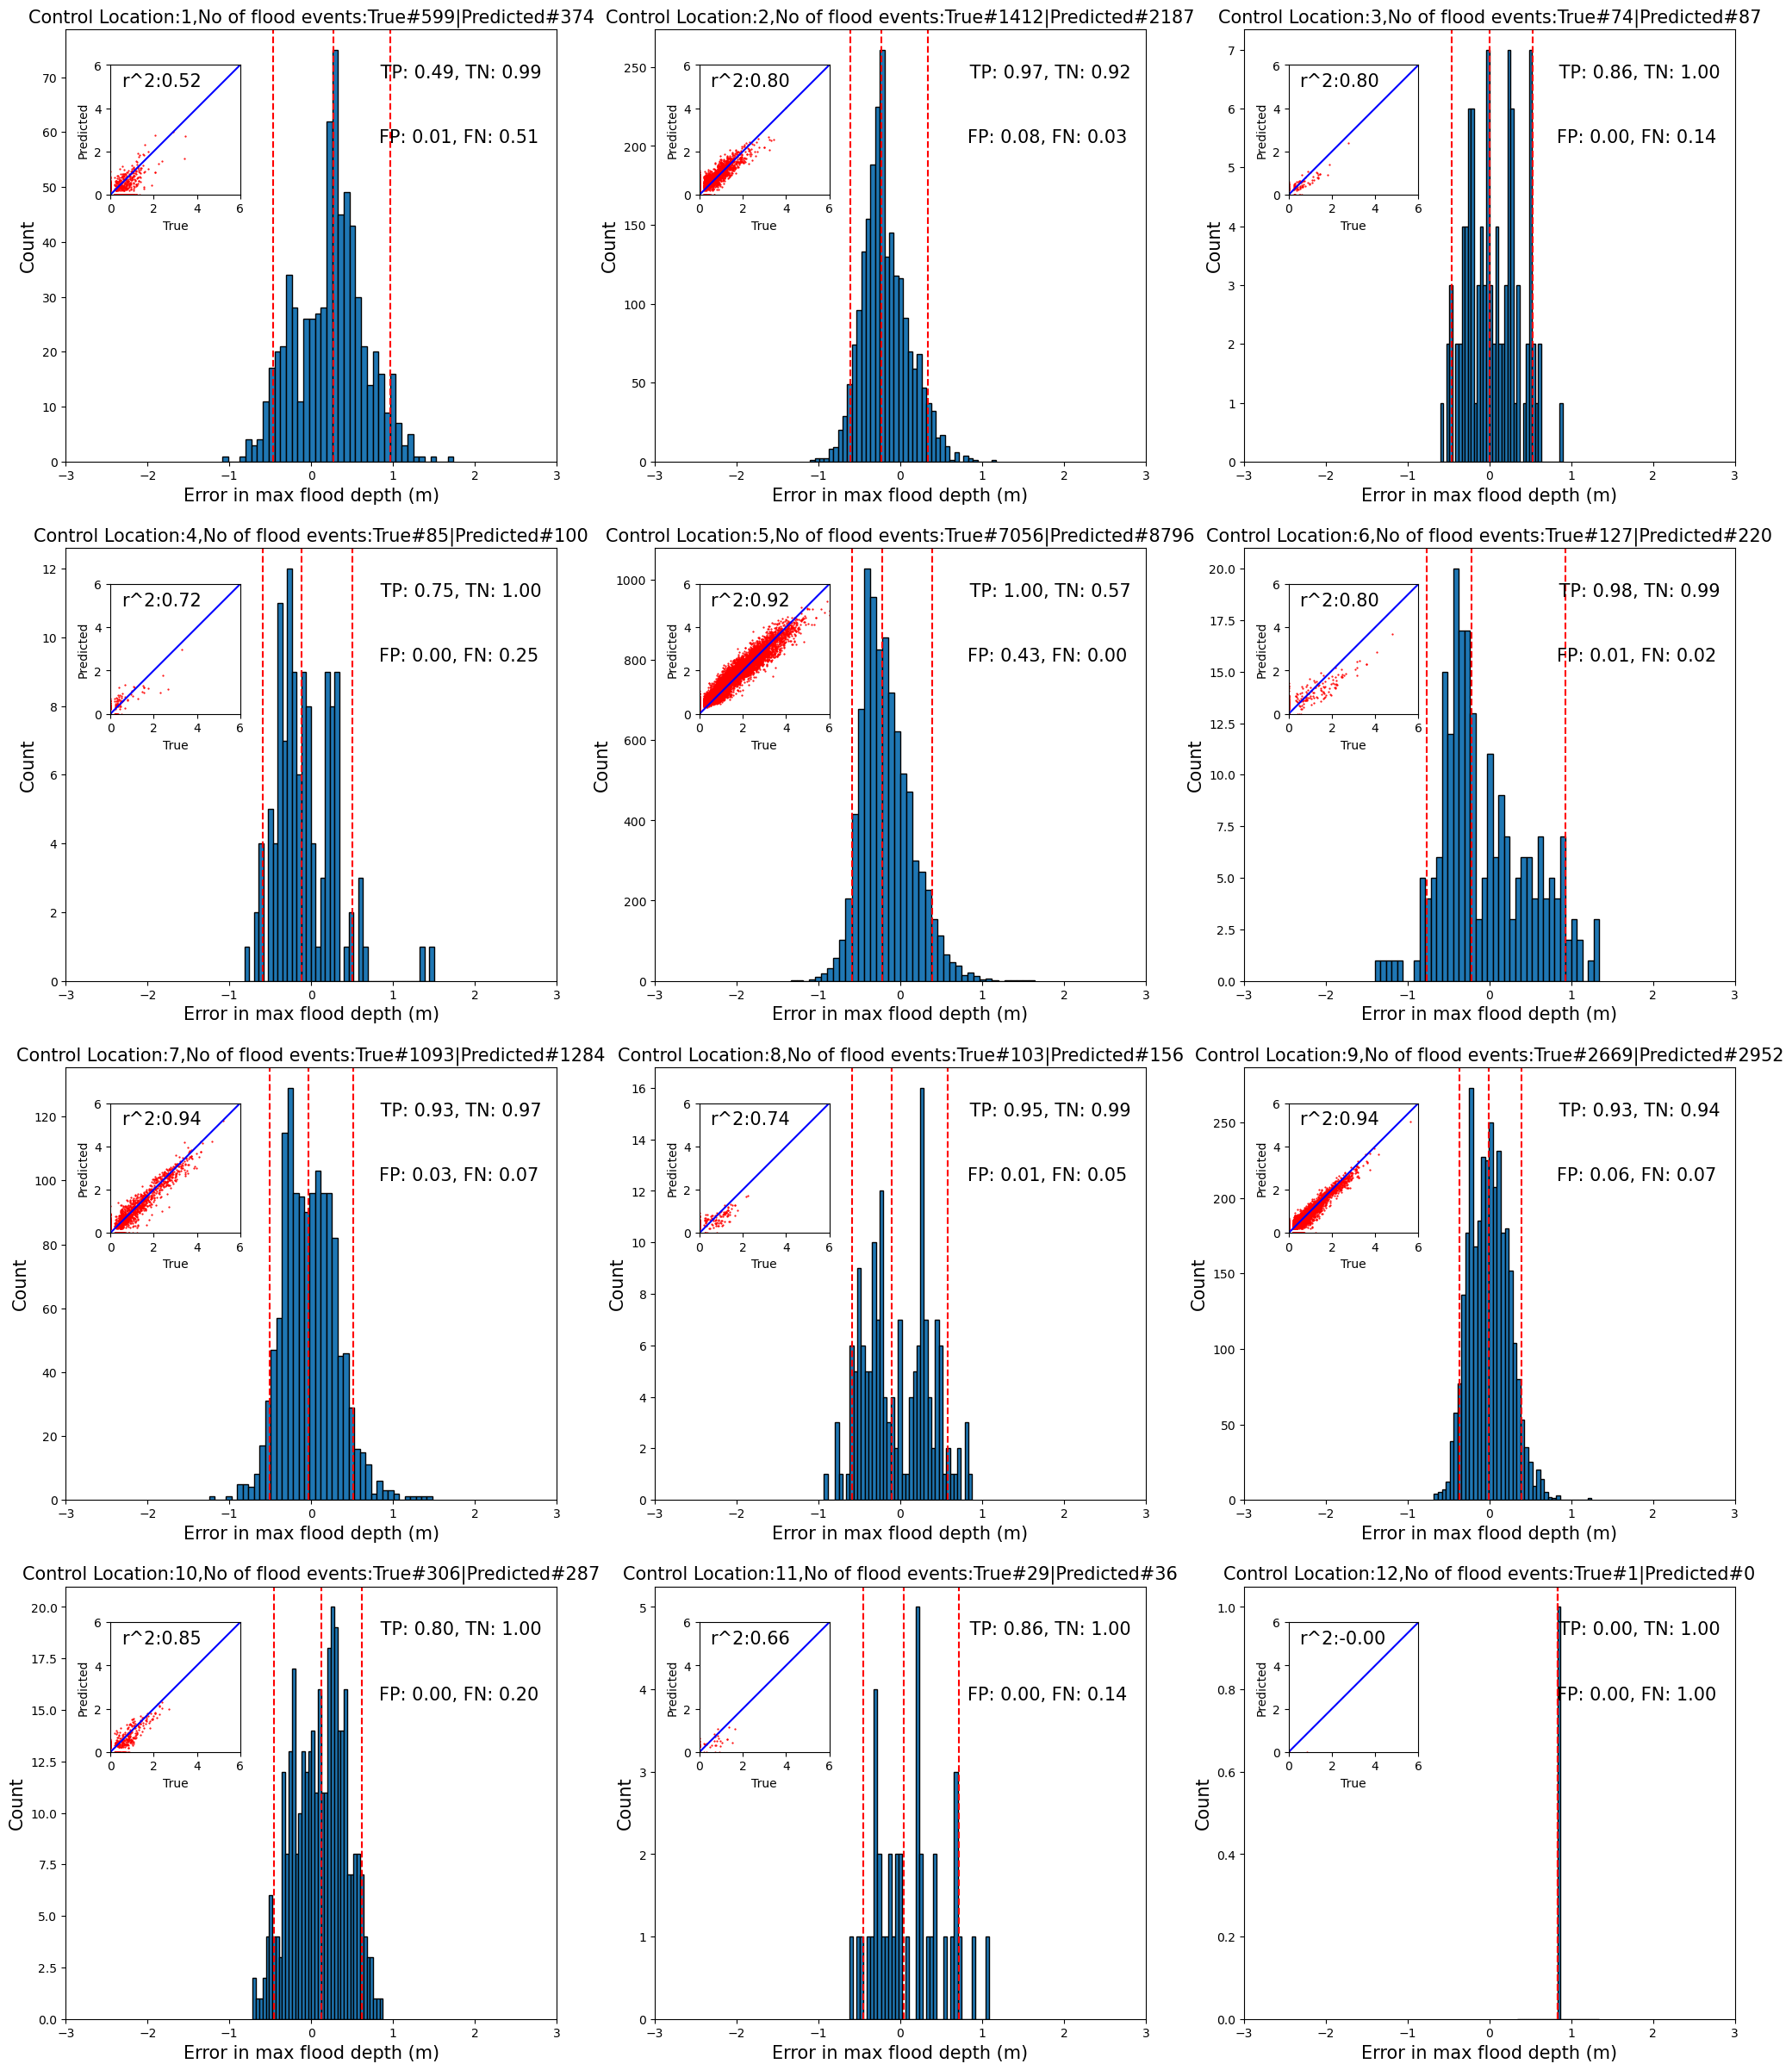

<Figure size 500x1000 with 0 Axes>

In [14]:

#plot the errors for the control locations as subplot from all events as histogram
plt.figure(figsize=(25, 30))
for i in range(len(locindices)):
    ax = plt.subplot(4, 3, i + 1)   
    # Plot the histogram of errors for the control locations
    plt.hist(er_list[er_list[:,i]!=0,i],bins=40,edgecolor='black',)
    quantiles = np.percentile(er_list[er_list[:,i]!=0,i], [5, 50, 95])
    # Plot quantile lines
    for q in quantiles:
        ax.axvline(q, color='red', linestyle='--', label=f'Q{int(q)}')
    ax.set_xlim(-3, 3)

    #calculate hit and mis for each location based on depth of true and prediction
    #events crossing the threshold say 0.2 are considered flooded
    neve = np.count_nonzero(true_pred_er[:,i]>threshold)
    neve_recon = np.count_nonzero(true_pred_er[:,i+len(locindices)]>threshold)
    print(f"Control Location:{i+1},No of flood events:{neve}/{len(true_pred_er[:,i])}")
    if neve == 0:
        TP = -999
        FN = -999
    else:
    #true positive: true>0.2 and pred>0.2
        TP = np.count_nonzero((true_pred_er[:,i]>threshold) & (true_pred_er[:,i+len(locindices)]>threshold))/(neve)
        FN = np.count_nonzero((true_pred_er[:,i]>threshold) & (true_pred_er[:,i+len(locindices)]<=threshold))/(neve)
    TN = np.count_nonzero((true_pred_er[:,i]<=threshold) & (true_pred_er[:,i+len(locindices)]<=threshold))/(len(true_pred_er[:,i])-neve)
    FP = np.count_nonzero((true_pred_er[:,i]<=threshold) & (true_pred_er[:,i+len(locindices)]>threshold))/(len(true_pred_er[:,i])-neve)
    plt.title(f"Control Location:{i+1},No of flood events:True#{neve}|Predicted#{neve_recon}",fontsize=15)
    plt.text(0.8, 0.9, f" TP: {TP:.2f}, TN: {TN:.2f}", horizontalalignment='center',verticalalignment='center', transform=plt.gca().transAxes,fontsize=15)
    plt.text(0.8, 0.75, f"FP: {FP:.2f}, FN: {FN:.2f}", horizontalalignment='center',verticalalignment='center', transform=plt.gca().transAxes,fontsize=15)
    plt.xlabel('Error in max flood depth (m)',fontsize=15)
    plt.ylabel('Count',fontsize=15)

    # Create a new inset axis for the scatter plot
    axins = inset_axes(ax, width="30%", height="30%", loc='upper left', borderpad=3)
    
    # Scatter plot of values (replace with your data)
    axins.plot([0, 1], [0, 1], transform=axins.transAxes, color='blue',)
    axins.scatter(true_pred_er[:,i], true_pred_er[:,i+len(locindices)], marker='o', color='red', label='Max Inun Depth',s=0.33)  # Customize marker and color as needed
    axins.text(0.5,5,f'r^2:{r2_score(true_pred_er[:,i], true_pred_er[:,i+len(locindices)]):.2f}',fontsize=15)
    axins.set_xlim(0, 6)  # Adjust x-axis limits for the scatter plot
    axins.set_ylim(0, 6)  # Adjust y-axis limits for the scatter plot
    axins.set_xlabel('True')
    axins.set_ylabel('Predicted')
    axins.set_aspect('equal', adjustable='box')
    
    
# Using enumerate to add index to the list of coordinates
coordinates_list = pd.DataFrame(control_points,columns=['lat','lon'])
coordinates_list['id'] = coordinates_list.index+1
plt.figure(figsize=(5,10))
plt.scatter(idx[:, 3], idx[:, 2], s=1, cmap='jet')
plt.scatter(coordinates_list['lon'],coordinates_list['lat'], marker='x', s=50, c='red')
for i, txt in enumerate(coordinates_list['id']):
    plt.annotate(txt, (coordinates_list['lon'][i]+0.001,coordinates_list['lat'][i]),fontsize=15)
plt.gca().set_aspect('equal', adjustable='box')

plt.show()


    # plt.grid()
# plt.suptitle(f"Error distribution for the control locations for {len(eve_perf)} test events")

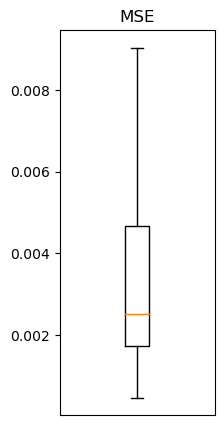

([], [])

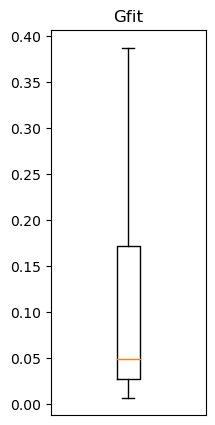

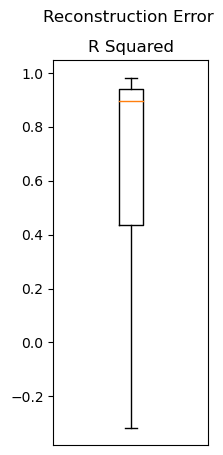

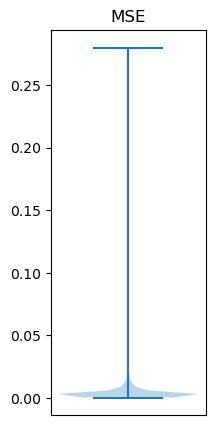

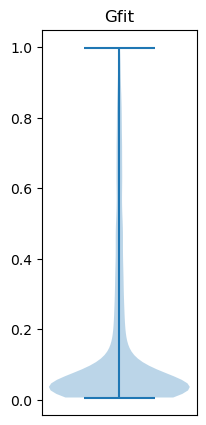

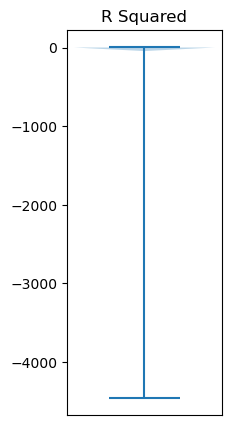

In [85]:
#plot the mse and r2 for all the events as box plot
plt.figure(figsize=(2, 5))
plt.boxplot(eve_perf[:,0],showfliers=False)
plt.title('MSE')
plt.xticks([])
plt.show()

#plot the mse and r2 for all the events as box plot
plt.figure(figsize=(2, 5))
plt.boxplot(eve_perf[:,2],showfliers=False)
plt.title('Gfit')
plt.xticks([])


plt.figure(figsize=(2, 5))
plt.boxplot(eve_perf[:,1],showfliers=False)
plt.title('R Squared')
plt.xticks([])

plt.suptitle(f"Reconstruction Error") # {len(eve_perf)} test events


# #make violin plot of the errors
# plt.figure(figsize=(15, 10))
# for i in range(4):
#     plt.subplot(2,2,i+1)
#     plt.violinplot(er_list[er_list[:,i]!=0,i],showmeans=True)
#     plt.xlim(-1,1)
#     plt.title(f"Control Location:{i+1}")
#     plt.xlabel('Error')
#     plt.ylabel('Count')
#     # plt.grid()


#make violin plot of the errors MSE and R2
plt.figure(figsize=(2, 5))
plt.violinplot(eve_perf[:,0],showmeans=False)
plt.title('MSE')
plt.xticks([])

plt.figure(figsize=(2, 5))
plt.violinplot(eve_perf[:,2],showmeans=False)
plt.title('Gfit')
plt.xticks([])

plt.figure(figsize=(2, 5))
plt.violinplot(eve_perf[:,1],showmeans=False)
plt.title('R Squared')
plt.xticks([])
# plt.suptitle(f"Reconstruction Error") # {len(eve_perf)} test events



In [110]:
for param in model.offshore_encoder.parameters():
    print(param.shape, param.requires_grad)

for param in model.offshore_fc1.parameters():
    print(param.shape, param.requires_grad)

torch.Size([64, 9, 3]) False
torch.Size([64]) False
torch.Size([128, 64, 3]) False
torch.Size([128]) False
torch.Size([256, 128, 3]) False
torch.Size([256]) False
torch.Size([64, 15360]) True
torch.Size([64]) True


In [87]:
for param in model.deform_encoder.parameters():
    print(param.shape, param.requires_grad)

for param in model.deform_fc1.parameters():
    print(param.shape, param.requires_grad)

torch.Size([16, 1, 3, 3]) False
torch.Size([16]) False
torch.Size([32, 16, 3, 3]) False
torch.Size([32]) False
torch.Size([64, 32, 3, 3]) False
torch.Size([64]) False
torch.Size([128, 64, 3, 3]) False
torch.Size([128]) False
torch.Size([64, 16128]) True
torch.Size([64]) True


In [88]:
for param in model.connect.parameters():
    print(param.shape, param.requires_grad)

torch.Size([128, 64]) True
torch.Size([128]) True


In [111]:
for param in model.parameters():
    print(param.shape, param.requires_grad)

torch.Size([64, 9, 3]) False
torch.Size([64]) False
torch.Size([128, 64, 3]) False
torch.Size([128]) False
torch.Size([256, 128, 3]) False
torch.Size([256]) False
torch.Size([64, 15360]) True
torch.Size([64]) True
torch.Size([16, 1, 3, 3]) False
torch.Size([16]) False
torch.Size([32, 16, 3, 3]) False
torch.Size([32]) False
torch.Size([64, 32, 3, 3]) False
torch.Size([64]) False
torch.Size([128, 64, 3, 3]) False
torch.Size([128]) False
torch.Size([64, 16128]) True
torch.Size([64]) True
torch.Size([128, 128]) True
torch.Size([128]) True
torch.Size([128, 128]) False
torch.Size([128]) False
torch.Size([1024, 128]) False
torch.Size([1024]) False
torch.Size([8964, 16]) False
torch.Size([8964]) False
torch.Size([8964, 16]) False
torch.Size([8964]) False
torch.Size([8964, 16]) False
torch.Size([8964]) False
torch.Size([8964, 16]) False
torch.Size([8964]) False
torch.Size([8964, 16]) False
torch.Size([8964]) False
torch.Size([8964, 16]) False
torch.Size([8964]) False
torch.Size([8964, 16]) Fals

In [120]:
for param in model.parameters():
    print(param.shape, param.requires_grad)

torch.Size([64, 9, 3]) False
torch.Size([64]) False
torch.Size([128, 64, 3]) False
torch.Size([128]) False
torch.Size([256, 128, 3]) False
torch.Size([256]) False
torch.Size([64, 15360]) True
torch.Size([64]) True
torch.Size([16, 1, 3, 3]) False
torch.Size([16]) False
torch.Size([32, 16, 3, 3]) False
torch.Size([32]) False
torch.Size([64, 32, 3, 3]) False
torch.Size([64]) False
torch.Size([128, 64, 3, 3]) False
torch.Size([128]) False
torch.Size([64, 16128]) True
torch.Size([64]) True
torch.Size([128, 128]) True
torch.Size([128]) True
torch.Size([128, 128]) False
torch.Size([128]) False
torch.Size([1024, 128]) False
torch.Size([1024]) False
torch.Size([8964, 16]) False
torch.Size([8964]) False
torch.Size([8964, 16]) False
torch.Size([8964]) False
torch.Size([8964, 16]) False
torch.Size([8964]) False
torch.Size([8964, 16]) False
torch.Size([8964]) False
torch.Size([8964, 16]) False
torch.Size([8964]) False
torch.Size([8964, 16]) False
torch.Size([8964]) False
torch.Size([8964, 16]) Fals

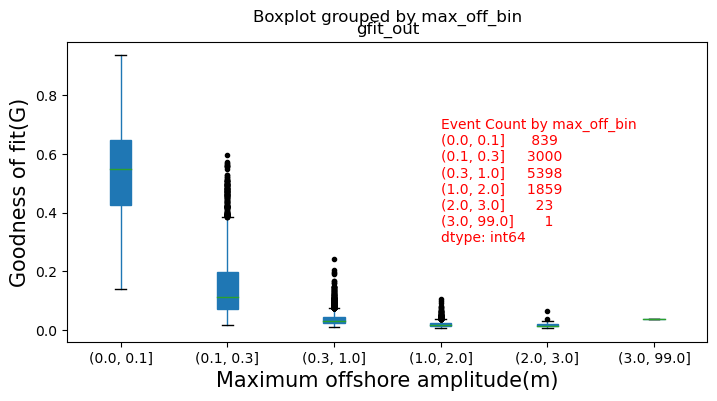

In [15]:
#append r2_scores_out to true_pred_er columns 
table = pd.DataFrame(true_pred_er)
table['r2_scores_out'] = r2_scores_out
table['id'] = event_list
table['gfit_out'] = Gfit_out
table['mse'] = eve_perf[:,0]
table['true'] = eve_perf[:,4]
table['pred'] = eve_perf[:,5]

#read sampling file and append to table based on event_id
sampling_file = pd.read_csv('/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/data/info/sampling_input_CT_38.csv')
table = table.merge(sampling_file, on='id', how='left')
#save to output file
# table.to_csv(f'{MLDir}/scripts/testing/out/BStrue_pred_er_r2scores_{test_size}.csv', index=False)

# Set the bin edges for 'max_off' values
bin_edges = [0, 0.1, 0.3, 1, 2, 3,99]  # Define your custom bin edges here

# Create a box plot of 'gfit_out' binned by 'max_off' using custom bin edges
plt.figure(figsize=(8, 4))
table['max_off_bin'] = pd.cut(table['max_off'], bin_edges)
table.boxplot(column='gfit_out', by='max_off_bin', vert=True, showfliers=True,widths=0.2,sym='k.',patch_artist=True,ax=plt.gca())
bin_counts = table.groupby('max_off_bin').size()
# Set labels and titles
plt.ylabel('Goodness of fit(G)',fontsize=15)
plt.xlabel('Maximum offshore amplitude(m)',fontsize=15)
plt.text(4, 0.3, f'Event Count by {bin_counts}',color='red')
#turn off grid
plt.grid(False)
# Show the plot
plt.show()


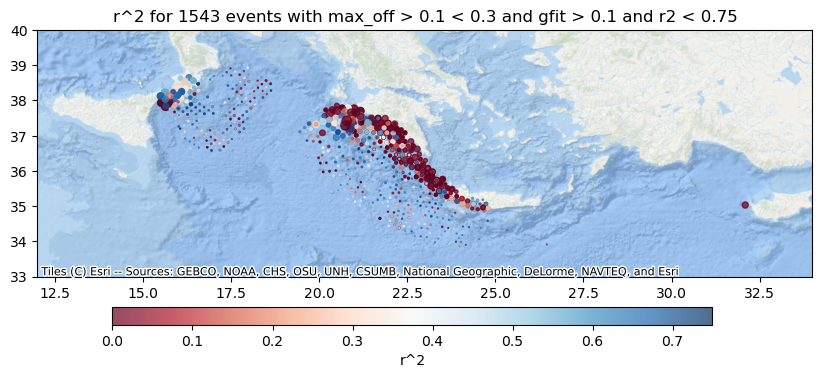

In [19]:
#plot events with lat lon and r2score as color
#load file
# sample_test = pd.read_csv(f'{MLDir}/scripts/testing/out/BStrue_pred_er_r2scores_{test_size}.csv')
sample_test = table

#select for max off between 0.1 and 0.4
sample_test = sample_test[sample_test['max_off'] > 0.1]
sample_test = sample_test[sample_test['max_off'] < 0.3]
sample_test = sample_test[sample_test['gfit_out'] > 0.1]
sample_test = sample_test[sample_test['r2_scores_out'] < 0.75]

#set r2score to -1 if it is negative
sample_test.loc[sample_test['r2_scores_out'] < 0, 'r2_scores_out'] = 0
# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 7))

# Set the title
ax.set_title('r^2 for ' + str(len(sample_test)) + ' events with max_off > 0.1 < 0.3 and gfit > 0.1 and r2 < 0.75')

# Create a scatter plot
scatter = ax.scatter(sample_test['lon'], sample_test['lat'], c=sample_test['r2_scores_out'],
                      cmap='RdBu', s=sample_test['mean_prob'] * 1500000, alpha=0.7)

# Set the plot limits
plt.xlim(12, 34)
plt.ylim(33, 40)

# Add a basemap
cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.OceanBasemap)

# Position the colorbar inside the map plot
cax = fig.add_axes([0.2, 0.25, 0.60, 0.025])  # Adjust the position as needed
cbar = plt.colorbar(scatter, cax=cax, orientation='horizontal', label='r^2')

# Show the plot
plt.show()


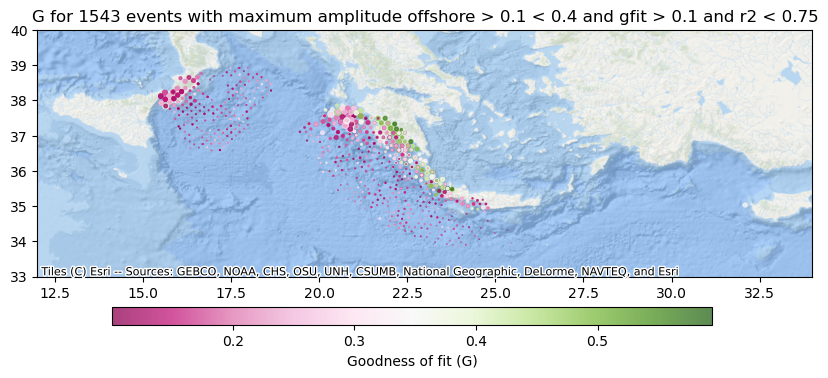

In [18]:
import matplotlib.pyplot as plt
import contextily as cx
#load file
# sample_test = pd.read_csv(f'{MLDir}/scripts/testing/out/BStrue_pred_er_r2scores_{test_size}.csv')
sample_test = table

sample_test = sample_test[sample_test['max_off'] > 0.1]
sample_test = sample_test[sample_test['max_off'] < 0.3]
sample_test = sample_test[sample_test['gfit_out'] > 0.1]
sample_test = sample_test[sample_test['r2_scores_out'] < 0.75]

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 7))

# Set the title
ax.set_title('G for ' + str(len(sample_test)) + ' events with maximum amplitude offshore > 0.1 < 0.3 and gfit > 0.1 and r2 < 0.75')

# Create a scatter plot
scatter = ax.scatter(sample_test['lon'], sample_test['lat'], c=sample_test['gfit_out'],
                      cmap='PiYG', s=sample_test['mean_prob'] * 600000, alpha=0.75)

# Set the plot limits
plt.xlim(12, 34)
plt.ylim(33, 40)

# Add a basemap
cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.OceanBasemap)

# Position the colorbar inside the map plot
cax = fig.add_axes([0.2, 0.25, 0.60, 0.025])  # Adjust the position as needed
cbar = plt.colorbar(scatter, cax=cax, orientation='horizontal', label='Goodness of fit (G)')

# Show the plot
plt.show()


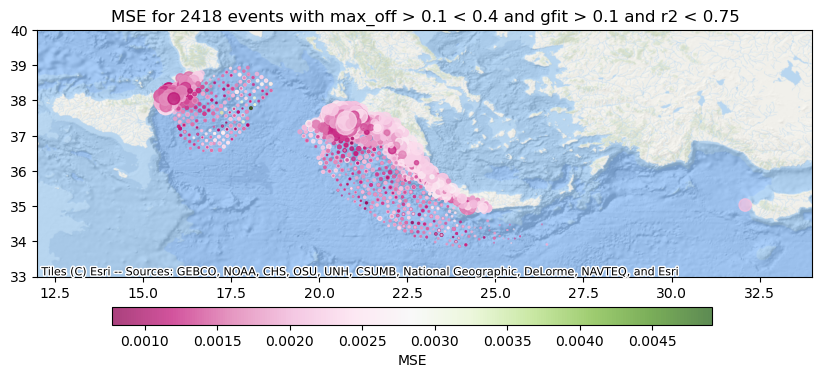

In [101]:
#load file
# sample_test = pd.read_csv(f'{MLDir}/scripts/testing/out/BStrue_pred_er_r2scores_{test_size}.csv')
sample_test = table

sample_test = sample_test[sample_test['max_off'] > 0.1]
sample_test = sample_test[sample_test['max_off'] < 0.3]
sample_test = sample_test[sample_test['gfit_out'] > 0.1]
sample_test = sample_test[sample_test['r2_scores_out'] < 0.75]

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 7))

# Set the title
ax.set_title('MSE for ' + str(len(sample_test)) + ' events with max_off > 0.1 < 0.4 and gfit > 0.1 and r2 < 0.75') 

# Create a scatter plot
scatter = ax.scatter(sample_test['lon'], sample_test['lat'], c=sample_test['mse'],
                      cmap='PiYG', s=sample_test['mean_prob'] * 6000000, alpha=0.75)

# Set the plot limits
plt.xlim(12, 34)
plt.ylim(33, 40)

# Add a basemap
cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.OceanBasemap)

# Position the colorbar inside the map plot
cax = fig.add_axes([0.2, 0.25, 0.60, 0.025])  # Adjust the position as needed
cbar = plt.colorbar(scatter, cax=cax, orientation='horizontal', label='MSE')

# Show the plot
plt.show()